# Aditya Joshi
## Neural Network and Backprop using Numpy

In [1]:
from sklearn import datasets
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from operator import add
from scipy.special import expit
import math
from tqdm import tqdm
import pickle as pk
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_batch(inputs, targets, batchsize):
	indices = np.random.permutation(len(inputs))
	for i in range(0, len(inputs), batchsize):
		ind = indices[i:batchsize+i]
		yield inputs[ind], targets[ind]

In [3]:
class Layer():
	def __init__(self, weights, bias, lr):
		self.weights = weights
		self.bias = bias
		self.lr = lr
        
	def fwd(self, X):
		return np.dot(X,self.weights) + self.bias
    
	def bkwd(self, X, grads):
		grad_input = np.dot(grads,self.weights.T)
		grad_weights = np.dot(X.T,grads)    
		self.weights -= self.lr * grad_weights
		return grad_input

class ALayer():
    def __init__(self, obj, act):
        self.act = act
        self.obj=obj
        
    def fwd(self, X):
        return self.obj.dispatcher[self.act](X)

    def bkwd(self, X, grads):
        return grads*self.obj.dispatcher[self.act+'g'](X)

In [4]:
train_set = pd.read_csv("fashion-mnist_train.csv")
test_set = pd.read_csv("fashion-mnist_test.csv")
train_set = train_set.sample(frac=1).reset_index(drop=True)
val_set=train_set.iloc[0:12000-1]
train_set = train_set.drop(train_set.index[range(12000-1)])
y_train = np.array(train_set["label"])
y_test = np.array(test_set["label"])
y_val = np.array(val_set["label"])
del train_set["label"]
del test_set["label"]
del val_set["label"]
# X_train, X_val, y_train, y_val = train_test_split(train_set, y_train, test_size=0.2, random_state=42)
X_train = np.array(train_set)/255
X_test = np.array(test_set)/255
X_val = np.array(val_set)/255
X_train = X_train.reshape([X_train.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])

In [5]:
class MyNeuralNetwork():
    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'normal']

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        
        self.n_layers=n_layers
        self.layer_sizes=layer_sizes
        self.activation=activation
        self.lr=learning_rate
        self.weight_init=weight_init
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        self.layers=[]
        self.ep=num_epochs
        self.batch=batch_size
        self.training_error=[]
        self.validation_error=[]
        
        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')

        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
        pass
        
        
    def compare_with_mlp(self,loss_from_your_model,X,y):
        # comparing with MLP
        # X is all data and Y is all labels
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

        mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='relu',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.001, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)

        mlp.fit(X_train, y_train)

        loss_from_sklearn = mlp.loss_curve_

        plt.plot(loss_from_sklearn,label="sklearn")
        plt.plot(loss_from_your_model,label="your NN")
        plt.legend(loc="upper left")
        plt.savefig("result.png")
        plt.close()

    def relu(self, X):
        return np.maximum(0, X)

    def relu_grad(self, X):
        return (X>0)

    def sigmoid(self, X):
        return (1/(1+(np.exp(-X))))

    def sigmoid_grad(self, X):
        return (self.sigmoid(X)*(1-self.sigmoid(X)))

    def linear(self, X):
        return (X)

    def linear_grad(self, X):
        return (1)

    def tanh(self, X):
        return (np.sinh(X) / np.cosh(X))

    def tanh_grad(self, X):
        return (1-self.tanh(X)**2)

    def softmax(self, X):
        return np.exp(X) / np.exp(X).sum(axis=-1,keepdims=True)

    def softmax_grad(self, X):
        return (self.softmax(X)*(1-self.softmax(X)))

    def zero_init(self, shape):
        return (np.zeros(shape[0],shape[1]))

    def random_init(self, shape):
        return (np.random.rand(shape[0],shape[1]))*0.01

    def normal_init(self, shape):
        return np.random.normal(0,0.01,(shape[0],shape[1]))
    
    def error(self, y_pred, y):
        temp = y_pred[range(len(y_pred)),y]  #output of NN (without softmax), for given label in true y. So for a value in y, what is the corresponding value in y_pred
        return  -temp + np.log(np.sum(np.exp(y_pred),axis=-1)) 
    
    """   cross entropy loss: sum[-ylog(e^x/sum of exponentials)]=[-x+log(sum of exponentials)] 
          where x is output from NN for a particular label!!!!!!!!! 
          Also y is one hot encoded, so it equals 1 for the true label and 0 for rest   """

    def fit(self, X_train, y_train):
        for i in range(self.n_layers-1): # Layer initialisation
            self.layers.append(Layer(self.dispatcher[self.weight_init]([self.layer_sizes[i],self.layer_sizes[i+1]]), np.zeros((1,self.layer_sizes[i+1])), self.lr))
            self.layers.append(ALayer(self, self.activation))
        self.layers.pop()
        for epoch in range(self.ep):
            batches = list(get_batch(X_train, y_train, self.batch))
            loss_value = 0
            test_cost = 0
            for X,y in batches:
                values = []
                temp = np.copy(X)
                for i in self.layers:
                    values.append(i.fwd(temp))
                    temp=values[-1]
                inputs = [X] + values
                y_pred = values[-1]
                loss_value += self.error(y_pred, y)
                temp = np.zeros_like(y_pred)
                temp[np.arange(len(y_pred)),y] = 1 #One Hot Encoded Vector
                grads = (- temp + self.softmax(y_pred))/y_pred.shape[0] # Calculation gradient of Cross Entropy: Softmax values - One Hot encoded vector
                for j in range(len(self.layers)-1,-1,-1): # Backward Propagation
                    grads = self.layers[j].bkwd(inputs[j], grads)
                
            if(epoch==49 or epoch==99):
#                 print('shit')
                with open(str(epoch+1)+'_'+self.activation+'_'+'pkl', 'wb') as handle:
                    pk.dump(self, handle)

            loss_value /= (len(X_train)/self.batch)
            passed=[]
            temp = np.copy(X_val)
            for i in self.layers:
                passed.append(i.fwd(temp))
                temp=passed[-1]
            passed=passed[-1]
            self.validation_error.append(np.mean(self.error(passed, y_val)))
            self.training_error.append(np.mean(loss_value))
            print("Epoch:",epoch)
            print("Training Loss:", np.mean(loss_value))
            print("Validation Loss:", self.validation_error[-1])
        return self.training_error

        # fit function has to return an instance of itself or else it won't work with test.py
        return self

    def predict_proba(self, X):
        # return the numpy array y which contains the predicted values
        probabs = []
        temp=np.copy(X)
        for i in self.layers:
            probabs.append(i.fwd(temp))
            temp = probabs[-1]
        probabs=probabs[-1]
        return (self.softmax(probabs))

    def predict(self, X):
        # return the numpy array y which contains the predicted values
        preds=self.predict_proba(X)
        
        return (preds.argmax(axis=1))

    def score(self, X, y):
        pred=self.predict(X)
        acc=0
        for i in range(len(y)):
            if y[i]==pred[i]:
                acc+=1
        return pred,acc/len(X)

        # return the numpy array y which contains the predicted values
        return None
    def make_dispatcher(self):
        self.dispatcher={'relu':self.relu,'sigmoid':self.sigmoid, 'linear':self.linear, 'tanh':self.tanh, 'softmax':self.softmax,'zero':self.zero_init, 'random':self.random_init, 'normal':self.normal_init, 'sigmoidg':self.sigmoid_grad, 'relug':self.relu_grad, 'tanhg':self.tanh_grad, 'linearg':self.linear_grad}

In [6]:
a=MyNeuralNetwork(5, [784,256,128,64,10], "relu", 0.1, 'normal', 32, 100)
X=np.random.randn(784,1)
a.make_dispatcher()
# a.make_layers()
# probab=a.predict_proba((1,[X]))
# print(probab)
# preds=a.predict([X,X])
a.fit(X_train,y_train)

Epoch: 0
Training Loss: 1.9031040939969832
Validation Loss: 1.025772124147247
Epoch: 1
Training Loss: 0.7523717720015
Validation Loss: 1.2647448301933821
Epoch: 2
Training Loss: 0.5303908032476837
Validation Loss: 0.49035829275025716
Epoch: 3
Training Loss: 0.4381716278786819
Validation Loss: 1.1968743991305226
Epoch: 4
Training Loss: 0.3975211651276513
Validation Loss: 2.608386373743536
Epoch: 5
Training Loss: 0.37071961054985936
Validation Loss: 0.37938366844467564
Epoch: 6
Training Loss: 0.34837382222214996
Validation Loss: 3.182648549055345
Epoch: 7
Training Loss: 0.3330849061642216
Validation Loss: 0.8220522952582654
Epoch: 8
Training Loss: 0.31947203628315657
Validation Loss: 0.33409591588382886
Epoch: 9
Training Loss: 0.30638024537792075
Validation Loss: 0.38237413594960296
Epoch: 10
Training Loss: 0.2948153820406062
Validation Loss: 0.746672786892246
Epoch: 11
Training Loss: 0.28527952359763187
Validation Loss: 0.34254381618788854
Epoch: 12
Training Loss: 0.27668586546148166
Va

[1.9031040939969832,
 0.7523717720015,
 0.5303908032476837,
 0.4381716278786819,
 0.3975211651276513,
 0.37071961054985936,
 0.34837382222214996,
 0.3330849061642216,
 0.31947203628315657,
 0.30638024537792075,
 0.2948153820406062,
 0.28527952359763187,
 0.27668586546148166,
 0.2743673193787327,
 0.2654326898755862,
 0.2573041804867027,
 0.24843705810888922,
 0.24330360244552962,
 0.239907470924837,
 0.2311288245561242,
 0.2258682408514181,
 0.2256646730622126,
 0.2201106950263793,
 0.21565300971998297,
 0.2085163305765635,
 0.2031048154246315,
 0.2006219842505934,
 0.19612945813786087,
 0.19212409922251045,
 0.18865223397731504,
 0.18669758748093013,
 0.1813240253296243,
 0.18050353589530949,
 0.1731459918084079,
 0.16935683710931293,
 0.1722042057586232,
 0.17575021019481063,
 0.1625222140980251,
 0.162361998918861,
 0.16092212491887598,
 0.17492083336288394,
 0.15775371581445385,
 0.1540287018588435,
 0.15255195682730477,
 0.14916981873001525,
 0.14442209504480527,
 0.14019082382838

Text(0.5, 1.0, 'ReLU Loss Plots')

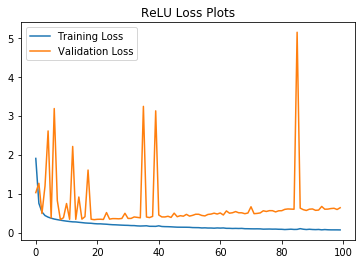

In [7]:
relu_train_loss=a.training_error
relu_val_loss=a.validation_error
plt.plot(a.training_error,label='Training Loss')
plt.plot(a.validation_error,label='Validation Loss')
plt.legend()
plt.title('ReLU Loss Plots')

In [8]:
a=MyNeuralNetwork(5, [784,256,128,64,10], "tanh", 0.1, 'normal', 32, 100)
X=np.random.randn(784,1)
a.make_dispatcher()
# a.make_layers()
# probab=a.predict_proba((1,[X]))
# print(probab)
# preds=a.predict([X,X])
a.fit(X_train,y_train)

Epoch: 0
Training Loss: 1.3713747492693324
Validation Loss: 0.6305049105269646
Epoch: 1
Training Loss: 0.5697007926800883
Validation Loss: 1.2067546066926713
Epoch: 2
Training Loss: 0.47663682180990297
Validation Loss: 1.4783580657689264
Epoch: 3
Training Loss: 0.43452898705880955
Validation Loss: 0.4115456328687096
Epoch: 4
Training Loss: 0.40052031300173474
Validation Loss: 0.4013245966200199
Epoch: 5
Training Loss: 0.37986727844437834
Validation Loss: 0.47660478258185673
Epoch: 6
Training Loss: 0.36317709598826126
Validation Loss: 0.6140196887672292
Epoch: 7
Training Loss: 0.3486188554435121
Validation Loss: 0.3872607352270015
Epoch: 8
Training Loss: 0.3356902870544246
Validation Loss: 0.44192168125843606
Epoch: 9
Training Loss: 0.3254659352113382
Validation Loss: 1.672134837839023
Epoch: 10
Training Loss: 0.3291019754082787
Validation Loss: 0.37204004483790504
Epoch: 11
Training Loss: 0.3082832984189104
Validation Loss: 0.5101925030451374
Epoch: 12
Training Loss: 0.2990337821482453

[1.3713747492693324,
 0.5697007926800883,
 0.47663682180990297,
 0.43452898705880955,
 0.40052031300173474,
 0.37986727844437834,
 0.36317709598826126,
 0.3486188554435121,
 0.3356902870544246,
 0.3254659352113382,
 0.3291019754082787,
 0.3082832984189104,
 0.29903378214824533,
 0.29140510859215785,
 0.28428793608767133,
 0.27696923941664864,
 0.26948965537821296,
 0.26359346300439374,
 0.2594442930211164,
 0.2522156645245048,
 0.24860308827577077,
 0.24193951377360823,
 0.23654095474305042,
 0.23205667645861378,
 0.22680039653530767,
 0.2233528765150689,
 0.21951934662608158,
 0.2132673669457476,
 0.21018668074939548,
 0.20548765450424128,
 0.20086728717427688,
 0.19579284647858586,
 0.1933941186320492,
 0.1894552922822042,
 0.1838497440609825,
 0.17890345047060072,
 0.17786118425220995,
 0.17135199243173577,
 0.1692214507059871,
 0.16865764267294833,
 0.23137321554881152,
 0.17924088226806903,
 0.19551017299469892,
 0.17325306144581243,
 0.16333505658598985,
 0.15895492516393134,
 0.

Text(0.5, 1.0, 'TanH Loss Plots')

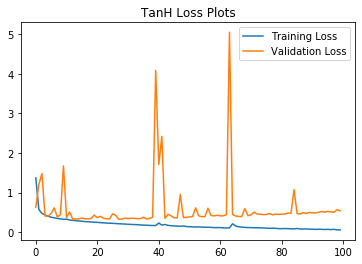

In [9]:
tanh_train_loss=a.training_error
tanh_val_loss=a.validation_error
plt.plot(a.training_error,label='Training Loss')
plt.plot(a.validation_error,label='Validation Loss')
plt.legend()
plt.title('TanH Loss Plots')

In [10]:
a=MyNeuralNetwork(5, [784,256,128,64,10], "sigmoid", 0.1, 'normal', 32, 100)
X=np.random.randn(784,1)
a.make_dispatcher()
# a.make_layers()
# probab=a.predict_proba((1,[X]))
# print(probab)
# preds=a.predict([X,X])
a.fit(X_train,y_train)

Epoch: 0
Training Loss: 2.3122244818506603
Validation Loss: 2.326307210382369
Epoch: 1
Training Loss: 2.307163329714706
Validation Loss: 2.307395383686334
Epoch: 2
Training Loss: 2.305816841653547
Validation Loss: 2.30551471008921
Epoch: 3
Training Loss: 2.3050247164910784
Validation Loss: 2.30492399534485
Epoch: 4
Training Loss: 2.304705270478678
Validation Loss: 2.303147655259129
Epoch: 5
Training Loss: 2.3045396419958815
Validation Loss: 2.3028035589857048
Epoch: 6
Training Loss: 2.3043493089002194
Validation Loss: 2.302651857504294
Epoch: 7
Training Loss: 2.304117108901689
Validation Loss: 2.3025336167739665
Epoch: 8
Training Loss: 2.3032913179615955
Validation Loss: 2.301663347708818
Epoch: 9
Training Loss: 2.300845355371651
Validation Loss: 2.2975485323369
Epoch: 10
Training Loss: 2.2914490885225307
Validation Loss: 2.2794853803297217
Epoch: 11
Training Loss: 2.210718013485167
Validation Loss: 2.0740415928870113
Epoch: 12
Training Loss: 1.996939674325641
Validation Loss: 1.978421

[2.3122244818506603,
 2.307163329714706,
 2.305816841653547,
 2.3050247164910784,
 2.304705270478678,
 2.3045396419958815,
 2.3043493089002194,
 2.304117108901689,
 2.3032913179615955,
 2.300845355371651,
 2.2914490885225307,
 2.210718013485167,
 1.996939674325641,
 1.9467138976656149,
 1.686694132443317,
 1.3225184499148448,
 1.0735691579899522,
 0.9200452786524151,
 0.8261044354999834,
 0.7394682250515814,
 0.6775320548769341,
 0.6318851942190065,
 0.5912859776013182,
 0.5539020350798867,
 0.5201521569546661,
 0.4960506577535493,
 0.47432569456341966,
 0.4585654978432275,
 0.4468626904761758,
 0.44240504320839313,
 0.4217431962344765,
 0.4137863641508283,
 0.4000026988892198,
 0.3917875294785018,
 0.3839302456909962,
 0.3762053279067515,
 0.36802121066243965,
 0.36086318590656297,
 0.3548922363174293,
 0.3504905144048543,
 0.3466819075977733,
 0.3406796119571351,
 0.33595873194397813,
 0.33146729926503393,
 0.3276486679968613,
 0.32307489498140385,
 0.31984569240064536,
 0.3160171034

Text(0.5, 1.0, 'Sigmoid Loss Plots')

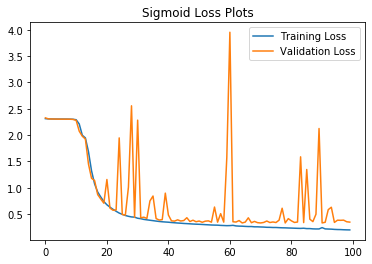

In [11]:
sigmoid_train_loss=a.training_error
sigmoid_val_loss=a.validation_error
plt.plot(a.training_error,label='Training Loss')
plt.plot(a.validation_error,label='Validation Loss')
plt.legend()
plt.title('Sigmoid Loss Plots')

In [12]:
a=MyNeuralNetwork(5, [784,256,128,64,10], "linear", 0.1, 'normal', 32, 100)
X=np.random.randn(784,1)
a.make_dispatcher()
# a.make_layers()
# probab=a.predict_proba((1,[X]))
# print(probab)
# preds=a.predict([X,X])
a.fit(X_train,y_train)

Epoch: 0
Training Loss: 1.4054865713067983
Validation Loss: 0.9234226878232581
Epoch: 1
Training Loss: 0.8331912667022989
Validation Loss: 0.8567960447630435
Epoch: 2
Training Loss: 0.6390460041285302
Validation Loss: 0.6071630130061283
Epoch: 3
Training Loss: 0.5889379014083729
Validation Loss: 0.6830232034774811
Epoch: 4
Training Loss: 0.5718743004768426
Validation Loss: 0.664730002458069
Epoch: 5
Training Loss: 0.5665779645614062
Validation Loss: 3.220752333220838
Epoch: 6
Training Loss: 0.5713488405375533
Validation Loss: 0.6515878176365273
Epoch: 7
Training Loss: 0.5516457495101411
Validation Loss: 0.7086905230004381
Epoch: 8
Training Loss: 0.5380061221674164
Validation Loss: 1.1194914924714578
Epoch: 9
Training Loss: 0.5268752867819096
Validation Loss: 0.5521283687919922
Epoch: 10
Training Loss: 0.5221756481417339
Validation Loss: 0.5201534288856047
Epoch: 11
Training Loss: 0.519161760677473
Validation Loss: 0.8527734163579127
Epoch: 12
Training Loss: 0.5127882690789066
Validatio

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: overflow encountered in exp
/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in true_divide


Epoch: 15
Training Loss: nan
Validation Loss: nan
Epoch: 16
Training Loss: nan
Validation Loss: nan
Epoch: 17
Training Loss: nan
Validation Loss: nan
Epoch: 18
Training Loss: nan
Validation Loss: nan
Epoch: 19
Training Loss: nan
Validation Loss: nan
Epoch: 20
Training Loss: nan
Validation Loss: nan
Epoch: 21
Training Loss: nan
Validation Loss: nan
Epoch: 22
Training Loss: nan
Validation Loss: nan
Epoch: 23
Training Loss: nan
Validation Loss: nan
Epoch: 24
Training Loss: nan
Validation Loss: nan
Epoch: 25
Training Loss: nan
Validation Loss: nan
Epoch: 26
Training Loss: nan
Validation Loss: nan
Epoch: 27
Training Loss: nan
Validation Loss: nan
Epoch: 28
Training Loss: nan
Validation Loss: nan
Epoch: 29
Training Loss: nan
Validation Loss: nan
Epoch: 30
Training Loss: nan
Validation Loss: nan
Epoch: 31
Training Loss: nan
Validation Loss: nan
Epoch: 32
Training Loss: nan
Validation Loss: nan
Epoch: 33
Training Loss: nan
Validation Loss: nan
Epoch: 34
Training Loss: nan
Validation Loss: nan


[1.4054865713067983,
 0.8331912667022989,
 0.6390460041285302,
 0.5889379014083729,
 0.5718743004768426,
 0.5665779645614062,
 0.5713488405375533,
 0.5516457495101411,
 0.5380061221674164,
 0.5268752867819096,
 0.5221756481417339,
 0.519161760677473,
 0.5127882690789066,
 0.5125647928887967,
 0.5089295184440333,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

Text(0.5, 1.0, 'Linear Loss Plots')

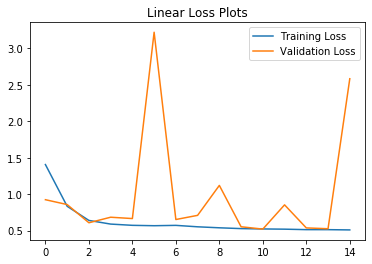

In [13]:
linear_train_loss=a.training_error
linear_val_loss=a.validation_error
plt.plot(a.training_error,label='Training Loss')
plt.plot(a.validation_error,label='Validation Loss')
plt.legend()
plt.title('Linear Loss Plots')

# Testing on test set

## ReLU

In [14]:
infile = open('50_relu_pkl','rb')
relu_50 = pk.load(infile)
infile.close()
relu_50_acc=relu_50.score(X_test,y_test)
print("ReLU, 50 epochs Testing Accuracy",relu_50_acc[1])

infile = open('100_relu_pkl','rb')
relu_100 = pk.load(infile)
infile.close()
relu_100_acc=relu_100.score(X_test,y_test)
print("ReLU, 100 epochs Testing Accuracy",relu_100_acc[1])

ReLU, 50 epochs Testing Accuracy 0.8885
ReLU, 100 epochs Testing Accuracy 0.8929


## TanH

In [15]:
infile = open('50_tanh_pkl','rb')
tanh_50 = pk.load(infile)
infile.close()
tanh_50_acc=tanh_50.score(X_test,y_test)
print("TanH, 50 epochs Testing Accuracy",tanh_50_acc[1])

infile = open('100_tanh_pkl','rb')
tanh_100 = pk.load(infile)
infile.close()
tanh_100_acc=tanh_100.score(X_test,y_test)
print("TanH, 100 epochs Testing Accuracy",tanh_100_acc[1])

TanH, 50 epochs Testing Accuracy 0.8909
TanH, 100 epochs Testing Accuracy 0.888


## Sigmoid

In [16]:
infile = open('50_sigmoid_pkl','rb')
sig_50 = pk.load(infile)
infile.close()
sig_50_acc=sig_50.score(X_test,y_test)
print("Sigmoid, 50 epochs Testing Accuracy",sig_50_acc[1])

infile = open('100_sigmoid_pkl','rb')
sig_100 = pk.load(infile)
infile.close()
sig_100_acc=sig_100.score(X_test,y_test)
print("Sigmoid, 100 epochs Testing Accuracy",sig_100_acc[1])

Sigmoid, 50 epochs Testing Accuracy 0.876
Sigmoid, 100 epochs Testing Accuracy 0.8893


## Linear

In [17]:
infile = open('50_linear_pkl','rb')
lin_50 = pk.load(infile)
infile.close()
lin_50_acc=lin_50.score(X_test,y_test)
print("Linear, 50 epochs Testing Accuracy",lin_50_acc[1])

infile = open('100_linear_pkl','rb')
lin_100 = pk.load(infile)
infile.close()
lin_100_acc=lin_100.score(X_test,y_test)
print("Linear, 100 epochs Testing Accuracy",lin_100_acc[1])

Linear, 50 epochs Testing Accuracy 0.1
Linear, 100 epochs Testing Accuracy 0.1


# SkLearn's implementation

## ReLU

/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0.5, 1.0, 'Comparing Losses: ReLU')

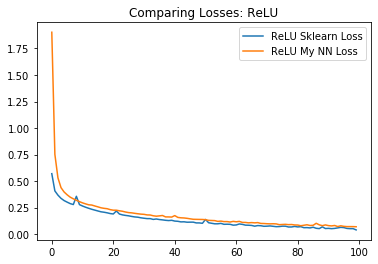

In [18]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='relu',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
mlp_relu.fit(X_train, y_train)
loss_sk = mlp_relu.loss_curve_
plt.plot(loss_sk,label="ReLU Sklearn Loss")
plt.plot(relu_train_loss,label="ReLU My NN Loss")
plt.legend()
plt.title("Comparing Losses: ReLU")

In [19]:
print("Testing Accuracy ReLU, SkLearn, 100 epochs",mlp_relu.score(X_test,y_test))
print("Testing Accuracy ReLU, My NN, 100 epochs",relu_100_acc[1])

Testing Accuracy ReLU, SkLearn, 100 epochs 0.8966
Testing Accuracy ReLU, My NN, 100 epochs 0.8929


In [20]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='relu',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=50, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
mlp_relu.fit(X_train, y_train)
print("Testing Accuracy ReLU, SkLearn, 50 epochs",mlp_relu.score(X_test,y_test))
print("Testing Accuracy ReLU, My NN, 50 epochs",relu_50_acc[1])

Testing Accuracy ReLU, SkLearn, 50 epochs 0.8925
Testing Accuracy ReLU, My NN, 50 epochs 0.8885


/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## TanH

/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0.5, 1.0, 'Comparing Losses: TanH')

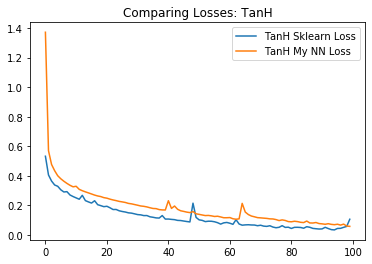

In [21]:
mlp_tanh = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='tanh',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
mlp_tanh.fit(X_train, y_train)
loss_sk = mlp_tanh.loss_curve_
plt.plot(loss_sk,label="TanH Sklearn Loss")
plt.plot(tanh_train_loss,label="TanH My NN Loss")
plt.legend()
plt.title("Comparing Losses: TanH")

In [22]:
print("Testing Accuracy TanH, SkLearn, 100 epochs",mlp_tanh.score(X_test,y_test))
print("Testing Accuracy TanH, My NN, 100 epochs",tanh_100_acc[1])

Testing Accuracy TanH, SkLearn, 100 epochs 0.8804
Testing Accuracy TanH, My NN, 100 epochs 0.888


In [23]:
mlp_tanh = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='tanh',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=50, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
mlp_tanh.fit(X_train, y_train)
print("Testing Accuracy TanH, SkLearn, 50 epochs",mlp_tanh.score(X_test,y_test))
print("Testing Accuracy TanH, My NN, 50 epochs",tanh_50_acc[1])

Testing Accuracy TanH, SkLearn, 50 epochs 0.8928
Testing Accuracy TanH, My NN, 50 epochs 0.8909


/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Sigmoid

/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0.5, 1.0, 'Comparing Losses: Sigmoid')

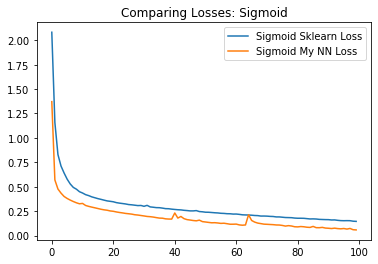

In [24]:
mlp_sigmoid = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='logistic',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
mlp_sigmoid.fit(X_train, y_train)
loss_sk = mlp_sigmoid.loss_curve_
plt.plot(loss_sk,label="Sigmoid Sklearn Loss")
plt.plot(tanh_train_loss,label="Sigmoid My NN Loss")
plt.legend()
plt.title("Comparing Losses: Sigmoid")

In [25]:
print("Testing Accuracy Sigmoid, SkLearn, 100 epochs",mlp_sigmoid.score(X_test,y_test))
print("Testing Accuracy Sigmoid, My NN, 100 epochs",sig_100_acc[1])

Testing Accuracy Sigmoid, SkLearn, 100 epochs 0.8771
Testing Accuracy Sigmoid, My NN, 100 epochs 0.8893


In [26]:
mlp_sig = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='logistic',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=50, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
mlp_sig.fit(X_train, y_train)
print("Testing Accuracy Sigmoid, SkLearn, 50 epochs",mlp_sig.score(X_test,y_test))
print("Testing Accuracy Sigmoid, My NN, 50 epochs",sig_50_acc[1])

Testing Accuracy Sigmoid, SkLearn, 50 epochs 0.8874
Testing Accuracy Sigmoid, My NN, 50 epochs 0.876


/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Linear

/home/test/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/test/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:231: RuntimeWarning: invalid value encountered in double_scalars
  loss += (0.5 * self.alpha) * values / n_samples
/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0.5, 1.0, 'Comparing Losses: Linear')

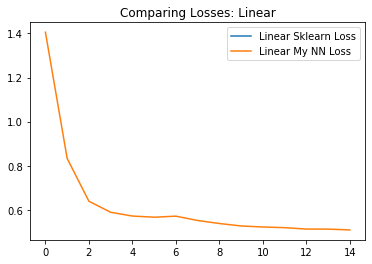

In [32]:
mlp_linear = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='identity',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=100, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
mlp_linear.fit(X_train, y_train)
loss_sk = mlp_linear.loss_curve_
plt.plot(loss_sk,label="Linear Sklearn Loss")
plt.plot(linear_train_loss,label="Linear My NN Loss")
plt.legend()
plt.title("Comparing Losses: Linear")

In [33]:
print("Testing Accuracy Linear, SkLearn, 100 epochs",mlp_linear.score(X_test,y_test))
print("Testing Accuracy Linear, My NN, 100 epochs",lin_100_acc[1])

Testing Accuracy Linear, SkLearn, 100 epochs 0.1
Testing Accuracy Linear, My NN, 100 epochs 0.1


In [34]:
mlp_lin = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation ='identity',solver = 'sgd' , alpha = 0, batch_size = 32,max_iter=50, learning_rate_init = 0.1, learning_rate = 'constant',shuffle=True,momentum = 0,nesterovs_momentum=False,validation_fraction = 0.1)
mlp_lin.fit(X_train, y_train)
print("Testing Accuracy Linear, SkLearn, 50 epochs",mlp_lin.score(X_test,y_test))
print("Testing Accuracy Linear, My NN, 50 epochs",lin_50_acc[1])

/home/test/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/test/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:231: RuntimeWarning: invalid value encountered in double_scalars
  loss += (0.5 * self.alpha) * values / n_samples


Testing Accuracy Linear, SkLearn, 50 epochs 0.1
Testing Accuracy Linear, My NN, 50 epochs 0.1


/home/test/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## All of the models (except Linear, which diverges :/ ) overfit, though SIGMOID fits the best and its accuracy is the highest(in most of the runs made), thus making it the best model.

In [35]:
import dill
dill.dump_session('backprop.db')